# Modelo detección de fraude biométrico en proceso de onboarding digital

## Desarrollo modelo CLASE III B: Verificar que la imagen no haya sido adulterada con una identificación completa sobrepuesta

### Descripción:
Este cuaderno contiene la Exploración, análisis exploratorio y desarrollo de la solución

#### Dependencias

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import dlib

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump, load


import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



import dlib
from PIL import Image, ImageDraw
import numpy as np

import os
import pandas as pd
from PIL import Image
import dlib


import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np


from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.callbacks import Callback

from PIL import Image, ImageEnhance, ImageOps, ImageFilter



In [2]:
# Rutas a los modelos y datos
model_paths = {
    'predictor_path': "../../modelos/shape_predictor_68_face_landmarks.dat",
    'face_rec_model_path': "../../modelos/dlib_face_recognition_resnet_model_v1.dat",
}

In [3]:
def crop_square(image, left=0, top=0, m=10, n=10):

    # Define las coordenadas de recorte
    right = left + m
    bottom = top + n

    # Recorta el área definida
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

In [4]:
def preprocess_image_for_edge_detection_rgb(image):

    # Convertir a escala de grises para simplificar la detección de bordes
    grayscale_image = image.convert("L")
    
    # Aplicar un filtro de suavizado para reducir el ruido
    blurred_image = grayscale_image.filter(ImageFilter.GaussianBlur(radius=0))
    
    # Mejorar el contraste para que los bordes sean más visibles
    enhancer = ImageEnhance.Contrast(blurred_image)
    high_contrast_image = enhancer.enhance(3)
    
    # Aplicar un filtro de detección de bordes
    edge_image = high_contrast_image.filter(ImageFilter.FIND_EDGES)
    
    # Convertir la imagen de detección de bordes a modo RGB
    rgb_edge_image = edge_image.convert("RGB")

    return rgb_edge_image

In [5]:

def process_and_combine_images(image, m=20, n=20):

    # Recortar las regiones de la parte superior izquierda y superior derecha
    left_image = crop_square(image, left=0, top=0, m=m, n=n)
    right_image = crop_square(image, left=image.width - m, top=0, m=m, n=n)
    
    # Aplicar el procesamiento de detección de bordes a cada recorte
    left_processed = preprocess_image_for_edge_detection_rgb(left_image)
    right_processed = preprocess_image_for_edge_detection_rgb(right_image)
    
    # Crear una nueva imagen uniendo ambas regiones procesadas
    combined_width = left_processed.width + right_processed.width
    combined_height = max(left_processed.height, right_processed.height)
    combined_image = Image.new("RGB", (combined_width, combined_height))
    combined_image.paste(left_processed, (0, 0))
    combined_image.paste(right_processed, (left_processed.width, 0))
    
    # Estandarizar la imagen combinada a un tamaño de 50x50
    standardized_image = combined_image.resize((50, 50), Image.Resampling.LANCZOS)

    return standardized_image




In [6]:


# Asumiendo que la función linearize_oval_face_contour ya ha sido definida como la discutida anteriormente.

def load_and_process_images(directory, label, output_size=(50, 50)):
    # Lista para almacenar los datos
    data = {'Image': [], 'Label': []}
    
    # Cargar modelos de dlib (asegúrate de que las rutas a los modelos están correctamente configuradas)

    # Obtener lista de archivos PNG en el directorio
    files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Iterar sobre cada archivo en el directorio con tqdm para visualizar el progreso
    for filename in tqdm(files, desc="Processing images"):
        # Construir la ruta completa al archivo
        file_path = os.path.join(directory, filename)
        
        # Cargar la imagen
        image = Image.open(file_path)
        
        # Procesar la imagen
        try:
            processed_image = process_and_combine_images(image, m=30, n=80)
            # Guardar la imagen y la etiqueta en el diccionario
            data['Image'].append(processed_image)
            data['Label'].append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Crear DataFrame desde el diccionario
    df = pd.DataFrame(data)
    
    return df

# Ejemplo de uso:
# directory_path = 'path_to_your_directory'
# label = 'your_label'
# df_images = load_and_process_images(directory_path, label)
# print(df_images)


In [7]:

# Cargar modelos de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_paths['predictor_path'])
face_rec_model = dlib.face_recognition_model_v1(model_paths['face_rec_model_path'])

In [8]:
demo_real = "../../data/train/CLASE III, FAKE_BW/ID_REAL/ID/ID_REAL_0.png"
demo_FAKE_III_B = "../../data/train/CLASE III, FAKE_BW/ID_FAKE_III/ID_B/ID_FAKE_III_B_144.png"


### Análisis y exploración
en general, en este caso se busca reemplazar el rostro, pero sin alterar el resto del documento, por ello se genera un punto de unión rectangular de las imágenes.
De manera similar al caso anterior, es posible focalizar la búsqueda a las zonas vulnerables de la imagen de validación

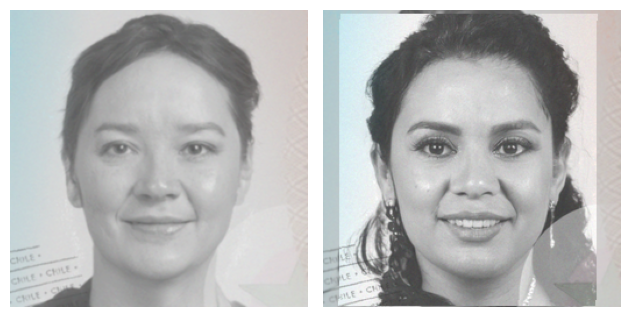

In [9]:
real = Image.open(demo_real)
fake_III_B = Image.open(demo_FAKE_III_B)

fig, axes = plt.subplots(1, 2) 

axes[0].imshow(real)
axes[0].axis('off')  

axes[1].imshow(fake_III_B)
axes[1].axis('off')



plt.tight_layout()
plt.show()

In [10]:
path_destino_ID_REAL = "../../data/train/CLASE III, FAKE_BW/ID_REAL/ID"
path_destino_VAL_REAL = "../../data/train/CLASE III, FAKE_BW/ID_REAL/VAL"

path_destino_ID_FAKE_III_B = "../../data/train/CLASE III, FAKE_BW/ID_FAKE_III/ID_B"
path_destino_VAL_FAKE_III_B = "../../data/train/CLASE III, FAKE_BW/ID_FAKE_III/VAL_B"




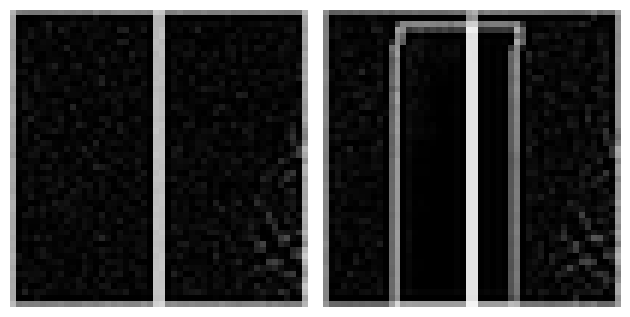

In [11]:
result_image_real = process_and_combine_images(real, m=30, n=80)
result_image_fake_III = process_and_combine_images(fake_III_B, m=30, n=80)

fig, axes = plt.subplots(1, 2) 

axes[0].imshow(result_image_real)
axes[0].axis('off')  

axes[1].imshow(result_image_fake_III )
axes[1].axis('off')



plt.tight_layout()
plt.show()

In [12]:
result_image_fake_III.size

(50, 50)

In [13]:
#df_real_B = pd.read_pickle('df_real_B.pkl')
#df_fake_III_B = pd.read_pickle('df_fake_III_B.pkl')

In [14]:
df_real_B = load_and_process_images(path_destino_ID_REAL, 0)
df_real_B

Processing images: 100%|██████████| 5000/5000 [00:09<00:00, 511.46it/s]


,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
...,...,...
4995,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4996,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4997,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4998,<PIL.Image.Image image mode=RGB size=50x50 at ...,0


In [15]:
#df_real_B.to_pickle('df_real_B.pkl')

In [16]:
df_fake_III_B = load_and_process_images(path_destino_ID_FAKE_III_B , 1)
df_fake_III_B 

Processing images: 100%|██████████| 5000/5000 [00:12<00:00, 401.03it/s]


,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
...,...,...
4995,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4996,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4997,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
4998,<PIL.Image.Image image mode=RGB size=50x50 at ...,1


In [17]:
#df_fake_III_B.to_pickle('df_fake_III_B.pkl')

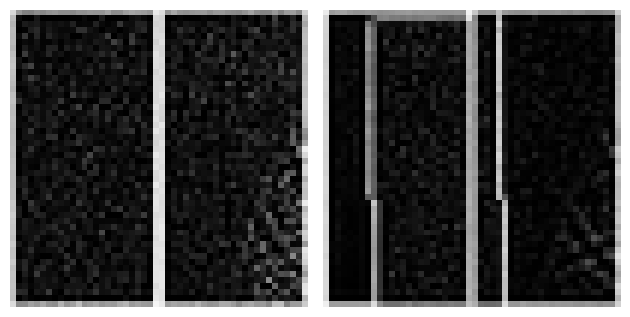

In [18]:

fig, axes = plt.subplots(1, 2) 

axes[0].imshow(df_real_B['Image'][2])
axes[0].axis('off')  

axes[1].imshow(df_fake_III_B['Image'][15])
axes[1].axis('off')  

plt.tight_layout()
plt.show()

In [19]:

# Concatenar los DataFrames en un solo DataFrame base
df_base = pd.concat([df_real_B, df_fake_III_B], ignore_index=True)
df_base

,Image,Label
0,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
1,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
2,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
3,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
4,<PIL.Image.Image image mode=RGB size=50x50 at ...,0
...,...,...
9995,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9996,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9997,<PIL.Image.Image image mode=RGB size=50x50 at ...,1
9998,<PIL.Image.Image image mode=RGB size=50x50 at ...,1


In [20]:
# Convertir imágenes de PIL Image a arrays de NumPy
df_base['Image'] = df_base['Image'].apply(lambda x: img_to_array(x))


In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = np.stack(df_base['Image'])  # Crear un array de numpy para las imágenes
y = df_base['Label'].values  # Etiquetas


In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)


In [23]:

# Normalizar los datos
X_train = X_train / 255.0
X_test = X_test / 255.0


PARA DETERMINAR EPOCH

In [24]:

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:

history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.4)



Epoch 1/40
66/66 [==============================] - 10s 141ms/step - loss: 0.3268 - accuracy: 0.8567 - val_loss: 0.2189 - val_accuracy: 0.9175
Epoch 2/40
66/66 [==============================] - 9s 143ms/step - loss: 0.1650 - accuracy: 0.9512 - val_loss: 0.1250 - val_accuracy: 0.9618
Epoch 3/40
66/66 [==============================] - 10s 146ms/step - loss: 0.1136 - accuracy: 0.9676 - val_loss: 0.1132 - val_accuracy: 0.9611
Epoch 4/40
66/66 [==============================] - 9s 144ms/step - loss: 0.0919 - accuracy: 0.9710 - val_loss: 0.0782 - val_accuracy: 0.9764
Epoch 5/40
66/66 [==============================] - 9s 143ms/step - loss: 0.0927 - accuracy: 0.9719 - val_loss: 0.0743 - val_accuracy: 0.9782
Epoch 6/40
66/66 [==============================] - 9s 144ms/step - loss: 0.0744 - accuracy: 0.9771 - val_loss: 0.0624 - val_accuracy: 0.9807
Epoch 7/40
66/66 [==============================] - 9s 144ms/step - loss: 0.0635 - accuracy: 0.9783 - val_loss: 0.0733 - val_accuracy: 0.9768
Epoc

In [26]:

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


94/94 [==============================] - 2s 24ms/step - loss: 0.0798 - accuracy: 0.9820
Test Accuracy: 98.20%


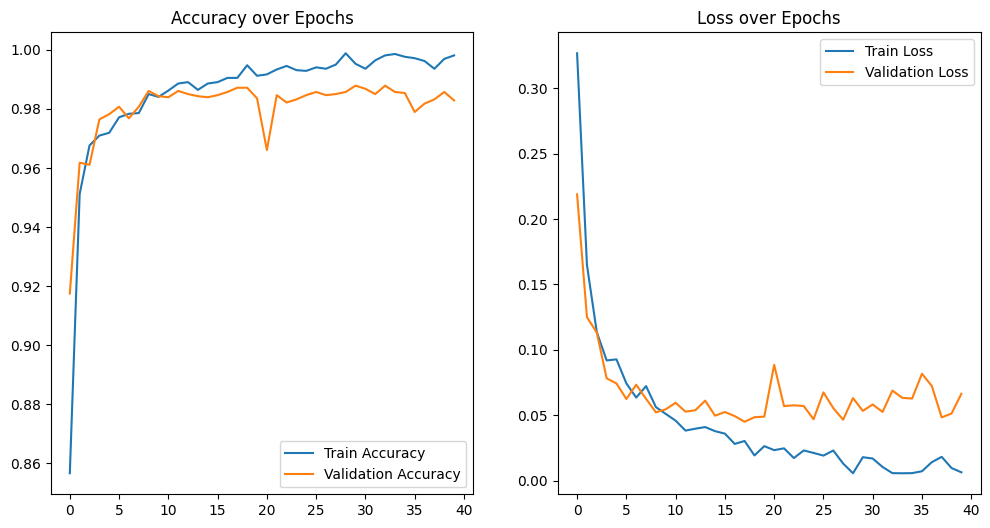

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_history(history)


FINAL

In [28]:

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3)



Epoch 1/10
77/77 [==============================] - 11s 137ms/step - loss: 0.3411 - accuracy: 0.8580 - val_loss: 0.1732 - val_accuracy: 0.9414
Epoch 2/10
77/77 [==============================] - 10s 136ms/step - loss: 0.1684 - accuracy: 0.9492 - val_loss: 0.1231 - val_accuracy: 0.9538
Epoch 3/10
77/77 [==============================] - 10s 135ms/step - loss: 0.1094 - accuracy: 0.9684 - val_loss: 0.0884 - val_accuracy: 0.9729
Epoch 4/10
77/77 [==============================] - 10s 135ms/step - loss: 0.0952 - accuracy: 0.9720 - val_loss: 0.0754 - val_accuracy: 0.9781
Epoch 5/10
77/77 [==============================] - 10s 136ms/step - loss: 0.0931 - accuracy: 0.9729 - val_loss: 0.0982 - val_accuracy: 0.9714
Epoch 6/10
77/77 [==============================] - 10s 136ms/step - loss: 0.0655 - accuracy: 0.9812 - val_loss: 0.0609 - val_accuracy: 0.9810
Epoch 7/10
77/77 [==============================] - 10s 136ms/step - loss: 0.0744 - accuracy: 0.9786 - val_loss: 0.0686 - val_accuracy: 0.9814

In [30]:

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


94/94 [==============================] - 2s 25ms/step - loss: 0.0579 - accuracy: 0.9850
Test Accuracy: 98.50%


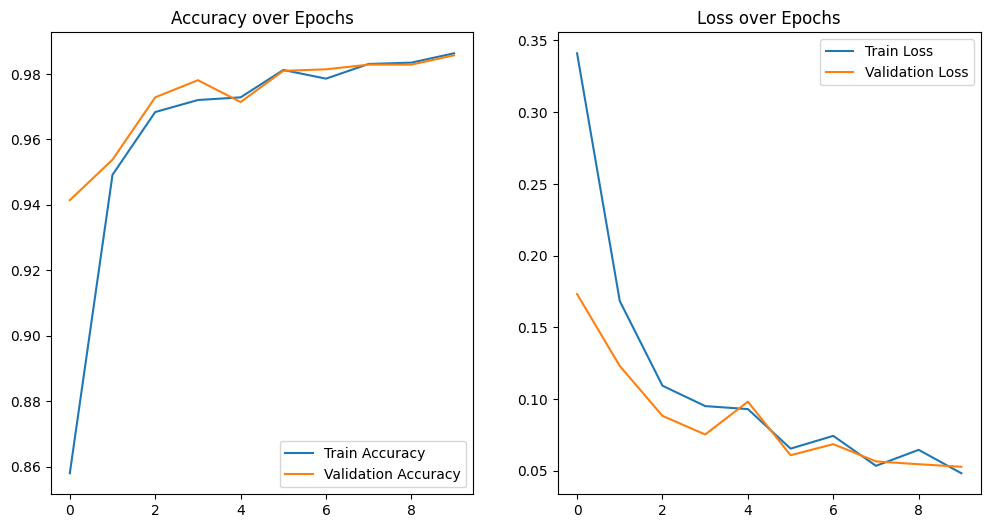

In [31]:

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_history(history)


94/94 [==============================] - 2s 25ms/step


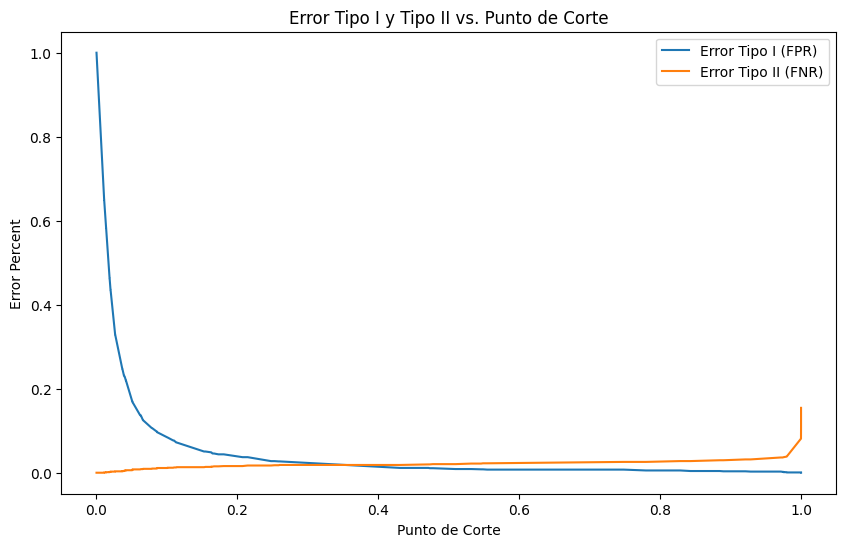

In [32]:
from sklearn.metrics import roc_curve

# Obtener probabilidades
y_probs = model.predict(X_test)[:, 0]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular Error Tipo I y II para cada umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr, label='Error Tipo I (FPR)')
plt.plot(thresholds, 1 - tpr, label='Error Tipo II (FNR)')
plt.title('Error Tipo I y Tipo II vs. Punto de Corte')
plt.xlabel('Punto de Corte')
plt.ylabel('Error Percent')
plt.legend()
plt.show()


94/94 [==============================] - 2s 24ms/step


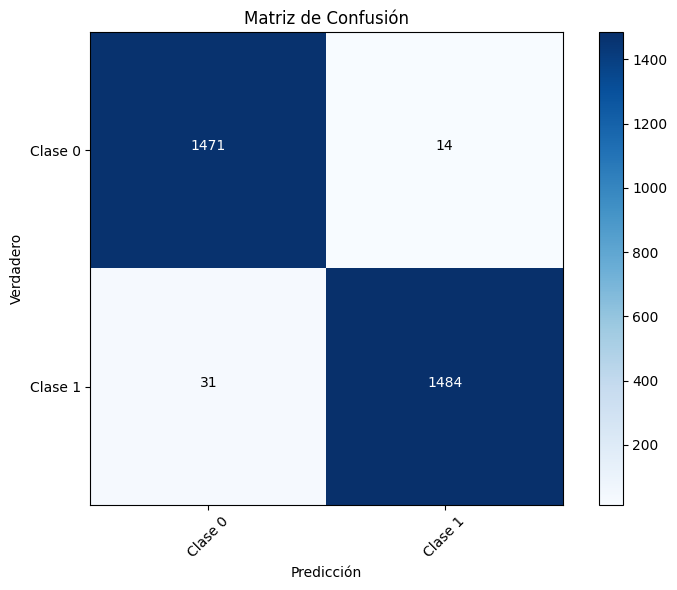

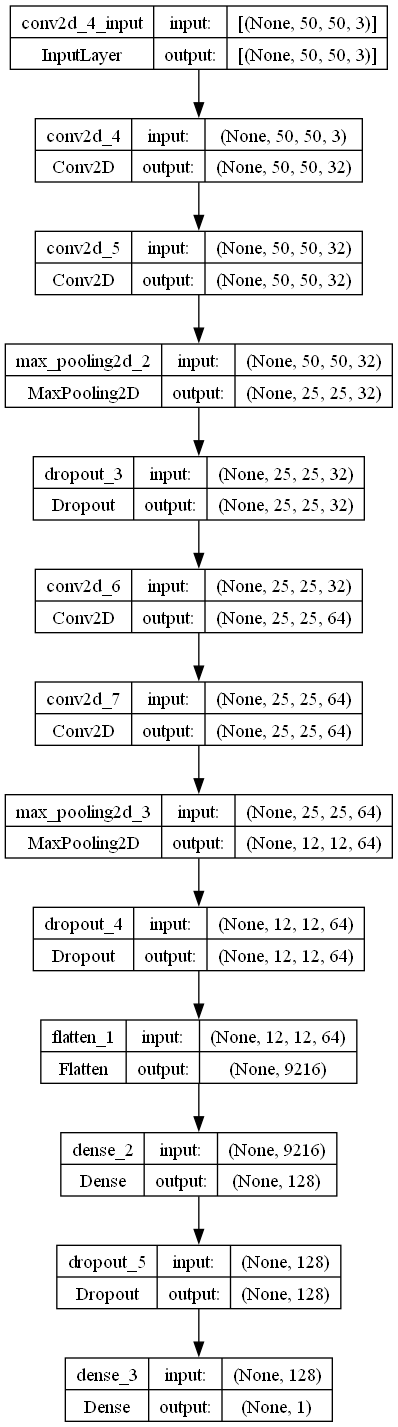

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import itertools  # Importar itertools

# Asumiendo que `model` es tu modelo entrenado y `X_test`, `y_test` son tus datos de prueba
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)  # Redondear y convertir a int si tus etiquetas son binarias

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(2)  # Ajustar según el número de clases
plt.xticks(tick_marks, ['Clase 0', 'Clase 1'], rotation=45)
plt.yticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')

# Añadir anotaciones de texto en las celdas
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Graficar la configuración del modelo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [34]:
#path_modelos_finales="./"


In [35]:
#model.save(path_modelos_finales+"/CLASE_III_B_CNN.h5")
